In [1]:
import sys
sys.path.insert(0, "../../../")


In [22]:
import optuna 

study = optuna.load_study(study_name="mnist_medium", storage="sqlite:///mnist.db")

# Get the best trial
best_trial = study.best_trial

print(f"Best Trial: {best_trial.number}")
print(f"Best Parameters: {best_trial.params}")
print(f"Best Accuracy: {best_trial.value}")

optuna.visualization.plot_optimization_history(study)

Best Trial: 388
Best Parameters: {'hidden_dim_0': 508, 'activation_0': 'gelu', 'normalization_0': 'batch_norm', 'hidden_dim_1': 739, 'activation_1': 'gelu', 'normalization_1': 'batch_norm', 'hidden_dim_2': 180, 'activation_2': 'sigmoid', 'normalization_2': 'batch_norm'}
Best Accuracy: 0.9846000075340271


In [21]:
best_trial_params = best_trial.params.copy()
best_trial_params["normalization_2"] = None
best_trial_params["activation_2"] = "gelu"

study.enqueue_trial(best_trial_params)

In [20]:
optuna.visualization.plot_slice(study, params=["activation_0", "activation_1"])

# MNIST Classification

We will build a neural network to classify images and apply it to the classical problem of the classification of the hand-written digits in the MNIST dataset (a must for everyone working with deep learning).
In this application, we will do this using a _fully connected neural network_ (a.k.a. _multi-layer perceptron_ or _dense neural network_), even though convolutional neural networks would be more appropriate.
We will also introduce the \emph{confusion matrix}, a common graphical tool used to gain insights into the performance of a classification algorithm.


### The MNIST dataset

Recognizing the handwritten digits of the MNIST dataset is a classical benchmark for machine learning. The task consists of recognizing handwritten digits from 0 to 9 in 28x28 pixel images. In the dataset, there are 6 * 10^4 training images and 10^4 test images.


### Training data

To import the images of the MNIST dataset into Python, we can download them using the package `torchvision`.


In [2]:
import torchvision

# Load the MNIST dataset
mnist_train = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)


Let us visualize some of the MNIST digits.
By visually inspecting them, we can check that the digits have been correctly imported and that the ground-truth labels are correct.

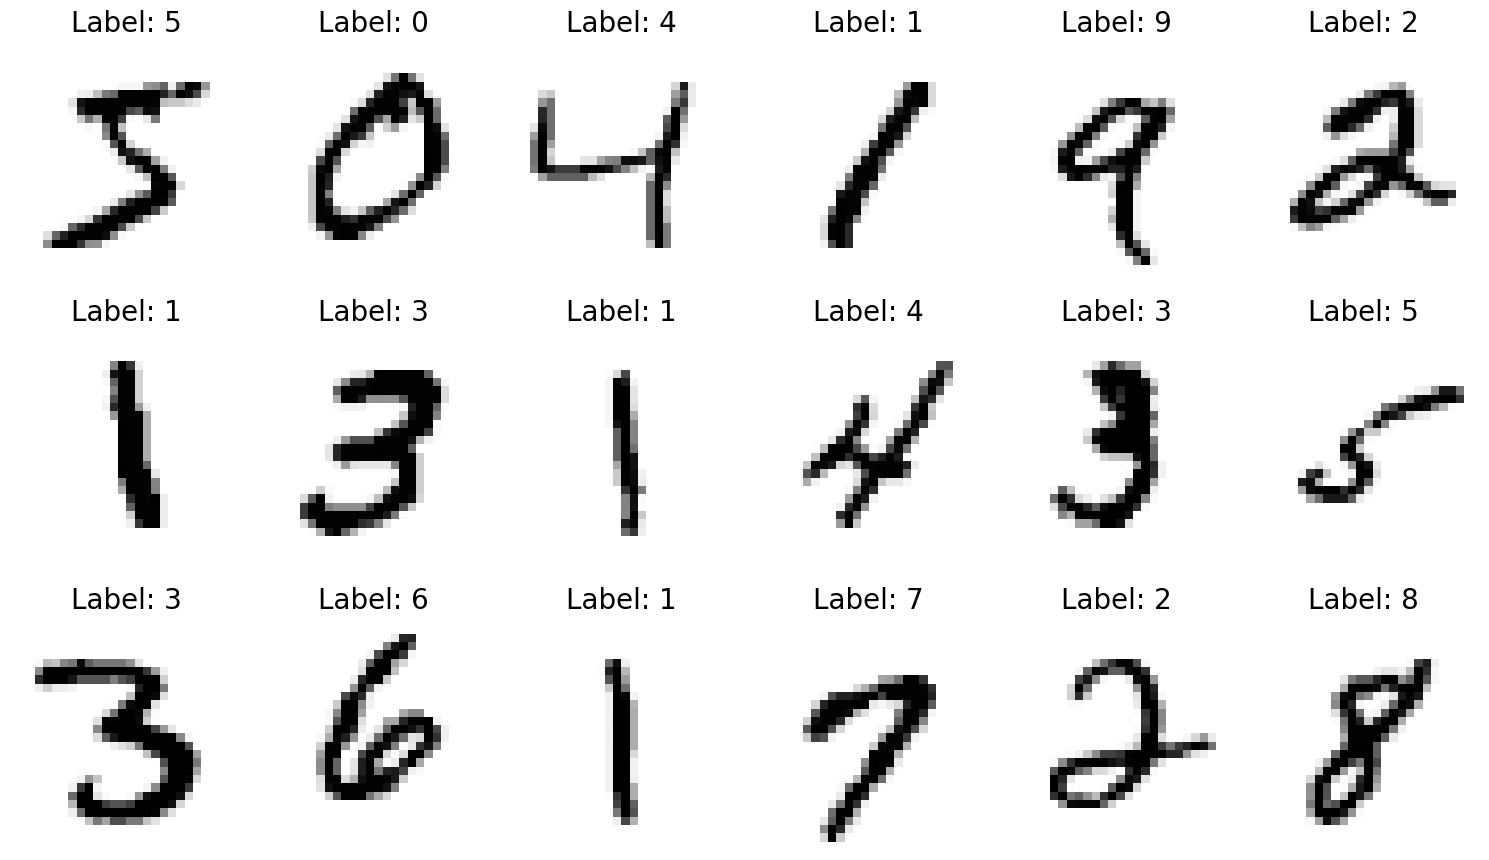

In [3]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 9))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    training_data, training_groundtruths = mnist_train[i]
    plt.title(f"Label: {training_groundtruths}", fontsize=20)
    plt.imshow(training_data.squeeze(), cmap="Greys") 
    plt.axis("off")

plt.tight_layout()
plt.show()

The _confusion matrix_ can be used to visualize what errors the neural network is making and to gain insights that can help us improve its architecture and training hyperparameters. 

A confusion matrix is a square matrix with a number of rows and columns equal to the number of classes in the classification problem, here 10. 
Each row and column corresponds to one class in the classification problem, ordered arbitrarily but equally for the two axes. 
In this case, we have a natural ordering of the classes, which is the order of the digits. 
An element c_i,j of the confusion matrix represents the number of times the neural network assigned the predicted class j to the actual class i. For example, in our case, c_3,5 would correspond to the number of times the neural network, when given an image depicting the digit 3, classified it as the digit 5. The name stems from the fact that this representation makes it easy to see which classes the model is most commonly confusing. 

 Here, we have chosen to assign the `groundtruth_digit` to the second axis and `predicted_digit` to the first axis, but the opposite is also a valid (and comon) choice.

In [4]:
import matplotlib.pyplot as plt
from seaborn import heatmap, cubehelix_palette
from numpy import zeros
import os
import pytorch_lightning as pl

def plot_confusion_matrix(model, dataset):
    confusion_matrix = zeros((10, 10))

    predicted_digits = []
    groundtruth_digits = []
    for image, true_digit in dataset:
        probabilities = model(image)
        _, predicted_digit = torch.max(probabilities.data, -1)
        predicted_digits.append(predicted_digit)
        groundtruth_digits.append(true_digit)

    for groundtruth_digit, predicted_digit in zip(groundtruth_digits, predicted_digits):
        confusion_matrix[groundtruth_digit, predicted_digit] += 1 

    # Plot the confusion matrix
    fig = plt.figure(figsize=(10, 8))
    heatmap(
        confusion_matrix,
        annot=True, 
        fmt=".0f", 
        square=True, 
        cmap=cubehelix_palette(light=0.95, as_cmap=True),
        vmax=200,
    )
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Ground truth digit", fontsize=15)
    return 


class PlottingCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {'train_loss': []}
        self.display_id = None
        
    def on_train_epoch_start(self, trainer, pl_module):
        self.plot_metrics(pl_module, trainer)
      
    def plot_metrics(self, model, trainer):
        model.eval()
        fig = plot_confusion_matrix(model, mnist_train)

        if self.display_id is None:
            display_handle = display(fig, display_id=True)
            self.display_id = display_handle.display_id
        else:
            update_display(fig, display_id=self.display_id)
        
        os.makedirs("figures", exist_ok=True)
        plt.savefig("figures/class_conditioned_epoch_{}.png".format(trainer.current_epoch))
        plt.close(fig)


# Compute the confusion matrix


## Neural network improvements

We now start a journey to improve our network and its training, as is usual in developing machine-learning solutions.
We will gradually introduce some new (and fundametal) concepts, to demonstrate how they affect the performance of the trained network, which provide valuable intuition for what hyperparameters are relevant.

In order to do so we will use the `Deeplay` library, which is an superset of `PyTorch` that offers a high-level interface while still allowing low-level access. This will allow us to focus on the concepts rather than the details of the implementation. Since `Deeplay` is a superset of `PyTorch`, we can use all the `PyTorch` functions and classes we have already defined.

First, we'll reimplement what we already have. We can base our implementation on the `MultiLayerPerceptron` base class which has the structure we want. It requires at least three arguments:

- `in_features`: the number of input features (can be `None`, which means that the number of input features will be inferred from the first batch of data passed to the network)
- `hidden_features`: a list of integers, each representing the number of neurons in a hidden layer
- `out_features`: the number of output features


In [5]:
import torch
import deeplay as dl

mlp = dl.MultiLayerPerceptron(28 * 28, [1500, 500, 250], 10)
mlp

MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [1500, 500, 250]
  (out_features): 10
  (depth): 4
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=1500, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=1500, out_features=500, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (2): Template(
      (layer): Linear(in_features=500, out_features=250, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=250, out_features=10, bias=True)
  (out_activation): Identity()
)

In [6]:

classifier = dl.Classifier(mlp)

In [ ]:
import pytorch_lightning as pl

